In [11]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NEERAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NEERAJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [13]:
test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


# Preprocessing

In [14]:
# Load stopwords, common words such as  "a," "the," "it," etc.
stop_words = stopwords.words('english')
    
#Initialize stemmer, which will take words and convert words to their "stem," e.g. Playing-> Play
ps = PorterStemmer() 

# Removes non-alphabetical characters, whitespaces, and converts all letters to lowercase
def clean_text(txt): 
    txt= txt.lower()   #lowercase
    txt= re.sub("[^a-zA-Z]"," ",txt) #Remove everything except alphabetical characters 
    txt= word_tokenize(txt) #tokenize (split into list and remove whitespace)
    
    #initialize list to store clean text
    clean_text=""
    
    #iterate over each word
    for w in txt:      
        #remove stopwords
        if w not in stop_words:
            #stem=ps.stem(w) #stem 
            stem=w
            clean_text = clean_text + stem +" " 
    return clean_text


# Train data
train['TITLE']=train['TITLE'].apply(clean_text)
train['ABSTRACT']=train['ABSTRACT'].apply(clean_text)

# Test data
test['TITLE']=test['TITLE'].apply(clean_text)
test['ABSTRACT']=test['ABSTRACT'].apply(clean_text)

In [15]:
train['combine']=train['TITLE']+train['ABSTRACT']
test['combine']=test['TITLE']+test['ABSTRACT']

In [16]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,combine
0,1,reconstructing subject specific effect maps,predictive models allow subject specific infer...,1,0,0,0,0,0,reconstructing subject specific effect maps pr...
1,2,rotation invariance neural network,rotation invariance translation invariance gre...,1,0,0,0,0,0,rotation invariance neural network rotation in...
2,3,spherical polyharmonics poisson kernels polyha...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...
3,4,finite element approximation stochastic maxwel...,stochastic landau lifshitz gilbert llg equatio...,0,0,1,0,0,0,finite element approximation stochastic maxwel...
4,5,comparative study discrete wavelet transforms ...,fourier transform infra red ftir spectra sampl...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...


In [17]:
test.head()

,ID,TITLE,ABSTRACT,combine
0,20973,closed form marginal likelihood gamma poisson ...,present novel understandings gamma poisson gap...,closed form marginal likelihood gamma poisson ...
1,20974,laboratory mid ir spectra equilibrated igneous...,meteorites contain minerals solar system aster...,laboratory mid ir spectra equilibrated igneous...
2,20975,case static amsdu aggregation wlans,frame aggregation mechanism multiple frames co...,case static amsdu aggregation wlans frame aggr...
3,20976,gaia eso survey inner disk intermediate age op...,milky way open clusters diverse terms age chem...,gaia eso survey inner disk intermediate age op...
4,20977,witness functions versus interpretation functi...,proving cryptographic protocol correct secrecy...,witness functions versus interpretation functi...


# Visualise the target labels

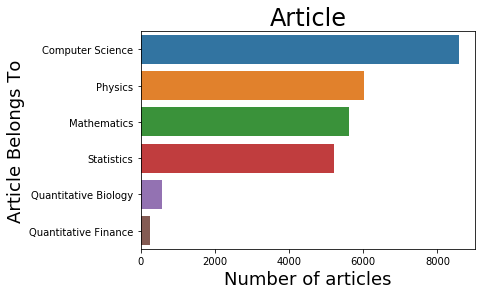

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
binary_labels=train[['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']]
categories = list(binary_labels.columns.values)
ax= sns.barplot(binary_labels.sum().values, categories)

plt.title("Article", fontsize=24)
plt.ylabel('Article Belongs To', fontsize=18)
plt.xlabel('Number of articles', fontsize=18)
#adding the text labels
rects = ax.patches
labels = binary_labels.sum().values
plt.show()

# Train and Validation split

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer


svc = LinearSVC(C=0.8, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(svc))])
parameters = {
    'tfidf__max_df': np.arange(0.7,1,0.1),
    'tfidf__min_df' : np.arange(0,0.3,0.025),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features' : [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000,None]
    
}

fold=KFold(random_state=9,shuffle=True,n_splits=10)
grid_search_tune = RandomizedSearchCV(pipeline, parameters, cv=fold, n_jobs=-1,random_state=9,n_iter=100)
grid_search_tune.fit(xtrain, ytrain)

print("Best parameters set:")
print(grid_search_tune.best_estimator_.steps) 

NameError: name 'TfidfVectorizer' is not defined

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# split dataset into training and validation set

tfidf_vectorizer = TfidfVectorizer(max_df=0.9999999999999999,min_df=0.0, ngram_range=(1, 3),max_features=45000)
xtrain, xval, ytrain, yval = train_test_split(train['combine'], binary_labels, test_size=0.2, random_state=9)

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

# Model Building

Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report

#Run Logistic Regrssion
logreg = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9)
logreg_classifier = OneVsRestClassifier(logreg)

# fit model on train data
logreg_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred=logreg_classifier.predict(xtrain_tfidf)
yval_pred = logreg_classifier.predict(xval_tfidf)

# evaluate performance
from sklearn.metrics import accuracy_score
print()
print("Accuracy score for Logistic Regression train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for Logistic Regression validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))


Accuracy score for Logistic Regression train:  0.7519222745425285
Accuracy score for Logistic Regression validation: 0.6545887961859357


f1-Score Train:  0.8921085632389824
f1-Score validation:  0.8299945858148349


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.91      0.86      1704
             Physics       0.90      0.87      0.89      1211
         Mathematics       0.78      0.88      0.83      1089
          Statistics       0.72      0.87      0.79      1069
Quantitative Biology       0.41      0.65      0.50       116
Quantitative Finance       0.58      0.82      0.68        44

           micro avg       0.79      0.88      0.83      5233
           macro avg       0.70      0.83      0.76      5233
        weighted avg       0.79      0.88      0.83      5233
         samples avg       0.83      0.90      0.84      5233



Hyperparameter tuning Logistic Regression

In [23]:
# For multiclass classification
from sklearn.multiclass import OneVsRestClassifier

# Models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      xtrain_tfidf, ytrain — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l2', dual=False, solver='liblinear',random_state=9,class_weight='balanced')
        model = OneVsRestClassifier(model)
        model.fit(xtrain_tfidf, ytrain)

    return model

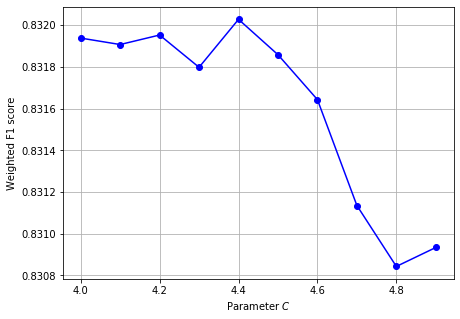

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

hypers = np.arange(4,5, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(xtrain_tfidf, ytrain, C=h, model='lr')
    temp_pred = f1_score(yval, temp_model.predict(xval_tfidf), average='micro')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('Weighted F1 score')
plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report

#Run Logistic Regrssion
logreg1 = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9,C=4.4,solver='liblinear')
logreg1_classifier = OneVsRestClassifier(logreg1)

# fit model on train data
logreg1_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred=logreg1_classifier.predict(xtrain_tfidf)
yval_pred = logreg1_classifier.predict(xval_tfidf)

# evaluate performance
from sklearn.metrics import accuracy_score
print()
print("Accuracy score for Logistic Regression train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for Logistic Regression validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))



Accuracy score for Logistic Regression train:  0.8806699648328068
Accuracy score for Logistic Regression validation: 0.665792610250298


f1-Score Train:  0.9520374386485562
f1-Score validation:  0.832028010688289


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.90      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.80      0.87      0.83      1089
          Statistics       0.74      0.83      0.78      1069
Quantitative Biology       0.44      0.57      0.49       116
Quantitative Finance       0.62      0.80      0.70        44

           micro avg       0.80      0.86      0.83      5233
           macro avg       0.72      0.80      0.76      5233
        weighted avg       0.81      0.86      0.83      5233
         samples avg       0.84      0.89      0.84      5233



LinearSVC Classifier

In [75]:
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight='balanced',random_state=9)
svc_classifier = OneVsRestClassifier(svc)
# train
svc_classifier.fit(xtrain_tfidf, ytrain)
# predict
ytrain_pred=svc_classifier.predict(xtrain_tfidf)
yval_pred = svc_classifier.predict(xval_tfidf)

print("Accuracy score for Gussian NB train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for Gussian NB validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for Gussian NB train:  0.9632830661024021
Accuracy score for Gussian NB validation: 0.665554231227652


f1-Score Train:  0.9854026570444481
f1-Score validation:  0.8271732010854309


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.88      0.85      1704
             Physics       0.91      0.86      0.88      1211
         Mathematics       0.81      0.86      0.83      1089
          Statistics       0.75      0.81      0.78      1069
Quantitative Biology       0.48      0.49      0.49       116
Quantitative Finance       0.73      0.75      0.74        44

           micro avg       0.81      0.84      0.83      5233
           macro avg       0.75      0.77      0.76      5233
        weighted avg       0.81      0.84      0.83      5233
         samples avg       0.84      0.87      0.83      5233



Hyperperameter Tuniing LinearSVC

In [25]:
# For multiclass classification
from sklearn.multiclass import OneVsRestClassifier

# Models
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      xtrain_tfidf, ytrain — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l2', dual=False, solver='liblinear',random_state=9,class_weight='balanced')
        model = OneVsRestClassifier(model)
        model.fit(xtrain_tfidf, ytrain)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
        model = OneVsRestClassifier(model)
        model.fit(xtrain_tfidf, ytrain)

    return model

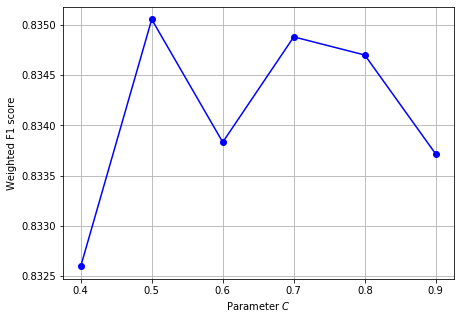

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

hypers = np.arange(0.4,1, 0.1)
res = []

for h in hypers:
    temp_model = train_classifier(xtrain_tfidf, ytrain, C=h, model='svm')
    temp_pred = f1_score(yval, temp_model.predict(xval_tfidf), average='micro')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('Weighted F1 score')
plt.show()

In [106]:
from sklearn.svm import LinearSVC

svc1 = LinearSVC(C=0.5, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
svc1_classifier = OneVsRestClassifier(svc1)
# train
svc1_classifier.fit(xtrain_tfidf, ytrain)
# predict
ytrain_pred=svc1_classifier.predict(xtrain_tfidf)
yval_pred = svc1_classifier.predict(xval_tfidf)

print("Accuracy score for Gussian NB train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for Gussian NB validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for Gussian NB train:  0.7860165703045836
Accuracy score for Gussian NB validation: 0.66388557806913


f1-Score Train:  0.9103343124285298
f1-Score validation:  0.8350552836686606


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.92      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.78      0.88      0.83      1089
          Statistics       0.72      0.88      0.79      1069
Quantitative Biology       0.44      0.53      0.48       116
Quantitative Finance       0.67      0.75      0.71        44

           micro avg       0.79      0.88      0.84      5233
           macro avg       0.72      0.80      0.76      5233
        weighted avg       0.80      0.88      0.84      5233
         samples avg       0.83      0.90      0.85      5233



SGDClassifier

In [87]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=9)


#Run SGDClassifier
sgd_classifier = OneVsRestClassifier(sgd)

# fit model on train data
sgd_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred=sgd_classifier.predict(xtrain_tfidf)
yval_pred = sgd_classifier.predict(xval_tfidf)

print("Accuracy score for Gussian NB train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for Gussian NB validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for Gussian NB train:  0.79924897180664
Accuracy score for Gussian NB validation: 0.6779499404052444


f1-Score Train:  0.9037685554278447
f1-Score validation:  0.826539720321333


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.89      0.85      1704
             Physics       0.96      0.81      0.88      1211
         Mathematics       0.88      0.78      0.83      1089
          Statistics       0.82      0.75      0.78      1069
Quantitative Biology       0.58      0.09      0.16       116
Quantitative Finance       0.71      0.27      0.39        44

           micro avg       0.86      0.80      0.83      5233
           macro avg       0.79      0.60      0.65      5233
        weighted avg       0.86      0.80      0.82      5233
         samples avg       0.84      0.83      0.82      5233



Hyperparameter tuning SGDClassifier

In [91]:
from sklearn.linear_model import SGDClassifier
sgd1 = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')

#Run SGDClassifier
sgd1_classifier = OneVsRestClassifier(sgd1)

# fit model on train data
sgd1_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred=sgd1_classifier.predict(xtrain_tfidf)
yval_pred = sgd1_classifier.predict(xval_tfidf)

print("Accuracy score for SGDClassifier train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for SGDClassifier validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for SGDClassifier train:  0.7966263336710974
Accuracy score for SGDClassifier validation: 0.6591179976162098


f1-Score Train:  0.9153096651360735
f1-Score validation:  0.8337092844897591


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.92      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.78      0.88      0.82      1089
          Statistics       0.72      0.88      0.79      1069
Quantitative Biology       0.43      0.57      0.49       116
Quantitative Finance       0.63      0.84      0.72        44

           micro avg       0.79      0.88      0.83      5233
           macro avg       0.71      0.83      0.76      5233
        weighted avg       0.80      0.88      0.84      5233
         samples avg       0.83      0.91      0.85      5233



# Bagging Classifier

In [94]:
from sklearn.ensemble import BaggingClassifier

Bagged Logistic Regression

In [95]:
lr = LogisticRegression(class_weight='balanced',n_jobs=-1,random_state=9,C=4.4,solver='liblinear')
lr_bag=BaggingClassifier(base_estimator=lr,random_state=9,n_jobs=-1)
lr_bag_classifier = OneVsRestClassifier(lr_bag)

# fit model on train data
lr_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred = lr_bag_classifier.predict(xtrain_tfidf)
yval_pred = lr_bag_classifier.predict(xval_tfidf)

print("Accuracy score for SGDClassifier train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for SGDClassifier validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for SGDClassifier train:  0.8384097276032664
Accuracy score for SGDClassifier validation: 0.6719904648390942


f1-Score Train:  0.9294902884593177
f1-Score validation:  0.8328971962616822


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.89      0.85      1704
             Physics       0.92      0.86      0.89      1211
         Mathematics       0.81      0.85      0.83      1089
          Statistics       0.75      0.82      0.79      1069
Quantitative Biology       0.48      0.52      0.50       116
Quantitative Finance       0.67      0.75      0.71        44

           micro avg       0.82      0.85      0.83      5233
           macro avg       0.74      0.78      0.76      5233
        weighted avg       0.82      0.85      0.83      5233
         samples avg       0.84      0.88      0.84      5233



LinearSVC baged

In [96]:
svc = LinearSVC(C=0.5, penalty='l2', class_weight='balanced', loss='hinge',random_state=9,dual=True)
svc_bag=BaggingClassifier(base_estimator=svc,random_state=9,n_jobs=-1)
svc_bag_classifier = OneVsRestClassifier(svc_bag)

# fit model on train data
svc_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred = svc_bag_classifier.predict(xtrain_tfidf)
yval_pred = svc_bag_classifier.predict(xval_tfidf)

print("Accuracy score for SGDClassifier train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for SGDClassifier validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for SGDClassifier train:  0.7860165703045836
Accuracy score for SGDClassifier validation: 0.66388557806913


f1-Score Train:  0.9103343124285298
f1-Score validation:  0.8350552836686606


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.92      0.86      1704
             Physics       0.91      0.87      0.89      1211
         Mathematics       0.78      0.88      0.83      1089
          Statistics       0.72      0.88      0.79      1069
Quantitative Biology       0.44      0.53      0.48       116
Quantitative Finance       0.67      0.75      0.71        44

           micro avg       0.79      0.88      0.84      5233
           macro avg       0.72      0.80      0.76      5233
        weighted avg       0.80      0.88      0.84      5233
         samples avg       0.83      0.90      0.85      5233



SGDClassifier Bagged

In [99]:
sgd = SGDClassifier(random_state=9,class_weight='balanced',n_jobs=-1,alpha=0.0001,loss='hinge')

sgd_bag=BaggingClassifier(base_estimator=sgd,random_state=9,n_jobs=-1)
sgd_bag_classifier = OneVsRestClassifier(sgd_bag)

# fit model on train data
sgd_bag_classifier.fit(xtrain_tfidf, ytrain)

# make predictions for validation set
ytrain_pred = sgd_bag_classifier.predict(xtrain_tfidf)
yval_pred = sgd_bag_classifier.predict(xval_tfidf)

print("Accuracy score for SGDClassifier train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for SGDClassifier validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for SGDClassifier train:  0.8205877093640103
Accuracy score for SGDClassifier validation: 0.6703218116805721


f1-Score Train:  0.9232869854129212
f1-Score validation:  0.835239852398524


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.81      0.90      0.86      1704
             Physics       0.92      0.86      0.89      1211
         Mathematics       0.80      0.86      0.83      1089
          Statistics       0.75      0.85      0.80      1069
Quantitative Biology       0.45      0.51      0.48       116
Quantitative Finance       0.62      0.80      0.70        44

           micro avg       0.81      0.87      0.84      5233
           macro avg       0.73      0.80      0.76      5233
        weighted avg       0.81      0.87      0.84      5233
         samples avg       0.84      0.89      0.85      5233



# Final Submition

In [101]:
X= train['combine']
X_test= test['combine']
y=binary_labels

# create TF-IDF features
# TF-IDF = Term frequency - inverse document frequency
# Used to predict how important a word is for a document
X = tfidf_vectorizer.fit_transform(X)
X_test = tfidf_vectorizer.transform(X_test)

In [111]:
# Voting Classifier

from sklearn.ensemble import VotingClassifier
SGDClassifier()
vote_est = [ 
    ('SGD', sgd_bag_classifier)]


voting = VotingClassifier(estimators = vote_est,voting= 'soft',n_jobs=-1)
voting_classifier=OneVsRestClassifier(voting)
# fit model on train data
voting_classifier.fit(xtrain_tfidf, ytrain)



# make predictions for validation set
ytrain_pred=voting_classifier.predict(xtrain_tfidf)
yval_pred = voting_classifier.predict(xval_tfidf)

print("Accuracy score for SGDClassifier train: ",accuracy_score(ytrain, ytrain_pred))
print("Accuracy score for SGDClassifier validation:",accuracy_score(yval, yval_pred))

print('\n')

print('f1-Score Train: ',f1_score(y_true=ytrain, y_pred=ytrain_pred, average='micro'))
print('f1-Score validation: ',f1_score(y_true=yval, y_pred=yval_pred, average='micro'))

print('\n')

print("Classification report:")
print(classification_report(yval, yval_pred, target_names=binary_labels.columns))

Accuracy score for SGDClassifier train:  0.8073553078619539
Accuracy score for SGDClassifier validation: 0.6743742550655543


f1-Score Train:  0.9146131014012563
f1-Score validation:  0.8347890726630737


Classification report:
                      precision    recall  f1-score   support

    Computer Science       0.82      0.90      0.86      1704
             Physics       0.93      0.85      0.89      1211
         Mathematics       0.81      0.86      0.83      1089
          Statistics       0.75      0.84      0.80      1069
Quantitative Biology       0.45      0.50      0.47       116
Quantitative Finance       0.63      0.77      0.69        44

           micro avg       0.81      0.86      0.83      5233
           macro avg       0.73      0.79      0.76      5233
        weighted avg       0.82      0.86      0.84      5233
         samples avg       0.84      0.89      0.84      5233



In [154]:
from sklearn.model_selection import cross_val_score

In [113]:
voting_classifier.fit(X,y)
y_pred = voting_classifier.predict(X_test)

col=['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
submit_test = pd.concat([test['ID'],pd.DataFrame(y_pred)], axis=1)
submit_test.columns=col
submit_test.to_csv('sample_submission.csv', index=False)
submit_test


,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,1,0,0,0
5,20978,0,0,0,1,0,0
6,20979,0,0,1,1,0,0
7,20980,1,1,0,1,0,0
8,20981,1,0,0,0,0,0
9,20982,0,1,0,0,0,0
